# Simple Univariate Time Series Anomaly Detection

## boilerplate

In [1]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
import random
# from arff2pandas import a2p

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

# rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED) 
 


In [3]:
import polars as pl
from io import StringIO
import math
df = pl.read_csv('../data/battery_1.csv')

We only need 'PACK1_CRIDATA_BATT_VOL'

## visualize fault and non-fault regions

In [4]:
filter_condition =  df['PACK1_CRIDATA_BATT_VOL'].cast(pl.Float32) != 0
voltage_data = (df['PACK1_CRIDATA_BATT_VOL']
                .filter(filter_condition)
                .cast(pl.Float32))

def convert_values(values):
    numerical_values = []
    for value in values:
        if value == 'False':
            numerical_values.append(0)
        elif value == 'True':
            numerical_values.append(1)
        else:
            # numerical_values.append(np.nan)
            numerical_values.append(-1)
    return numerical_values


fault_data = convert_values(df['BATT_PACK_1_FAULT']
                            .filter(filter_condition))


Text(0.5, 1.0, 'fault incidents')

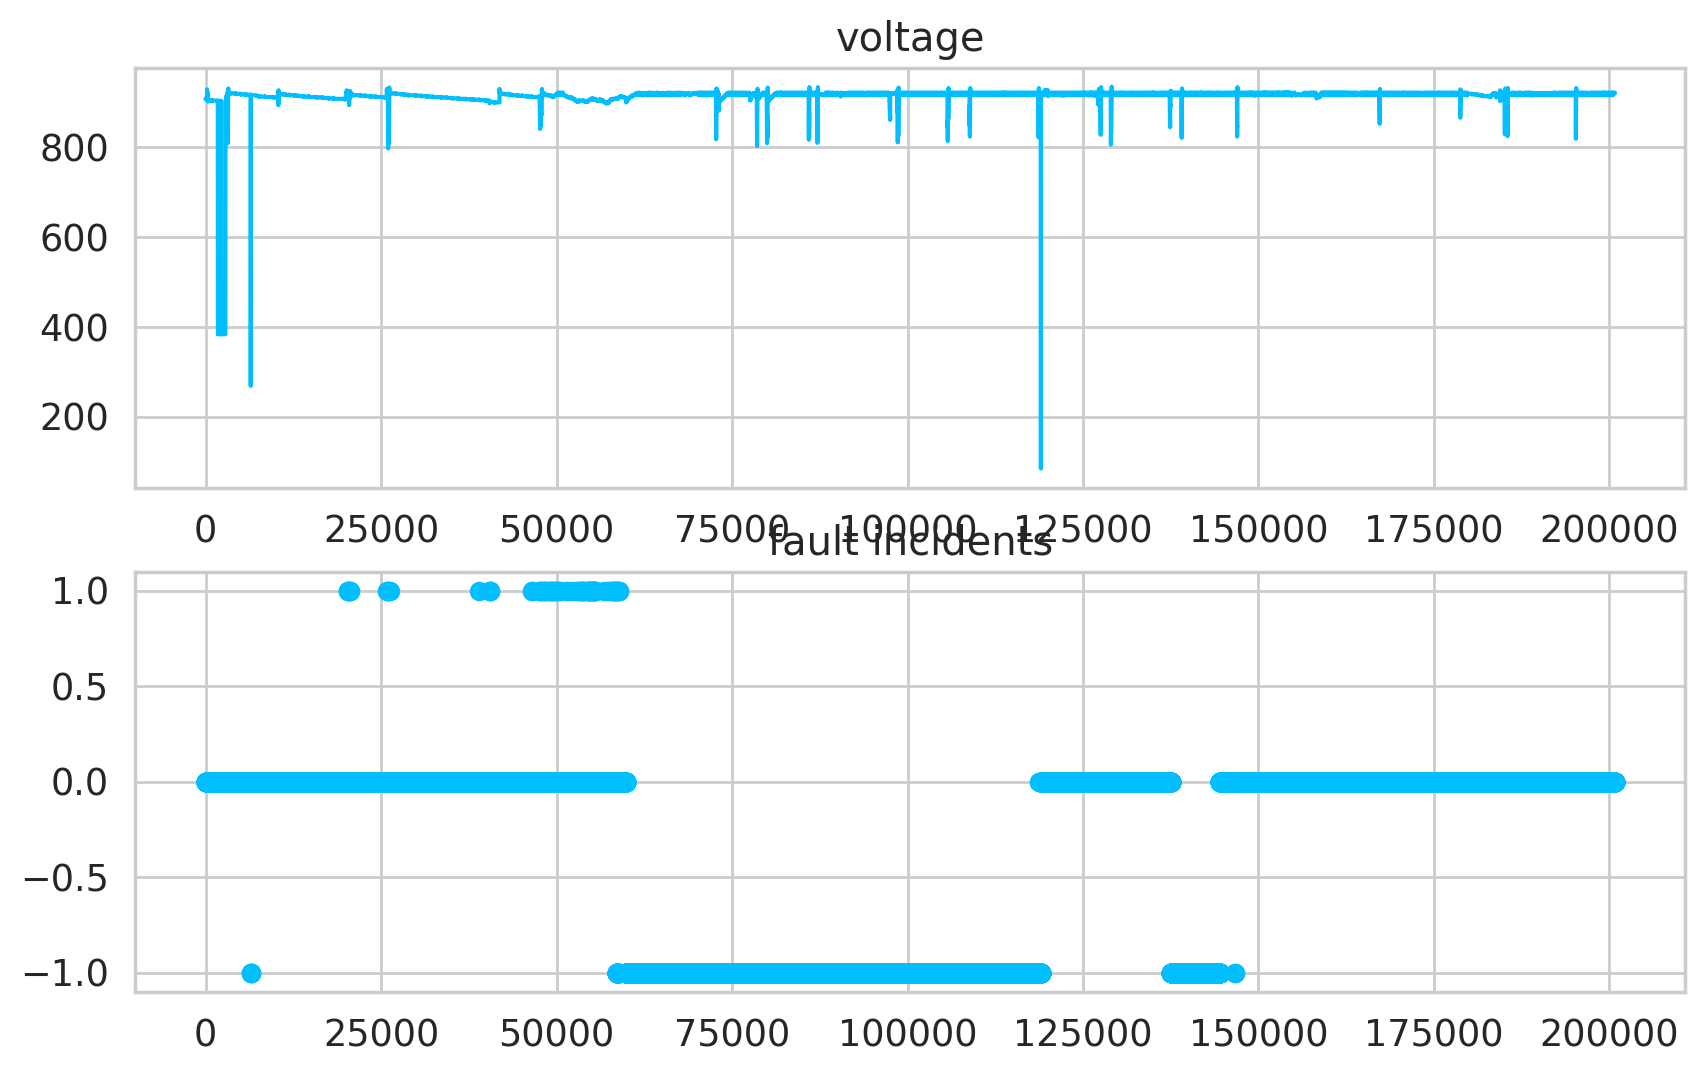

In [5]:

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,3 * 2))

axs[0].plot(voltage_data)
axs[0].set_title("voltage")
axs[1].scatter(range(len(fault_data)), fault_data)
axs[1].set_title("fault incidents")

Train region: 145000-end

Test region: 45000-60000

In [45]:
train_voltage_data = voltage_data[145000:]
test_voltage_data = voltage_data[85000:100000]
val_voltage_data = voltage_data[120000:135000]
fault_voltage_data = voltage_data[45000:60000]

Text(0.5, 1.0, 'fault incidents')

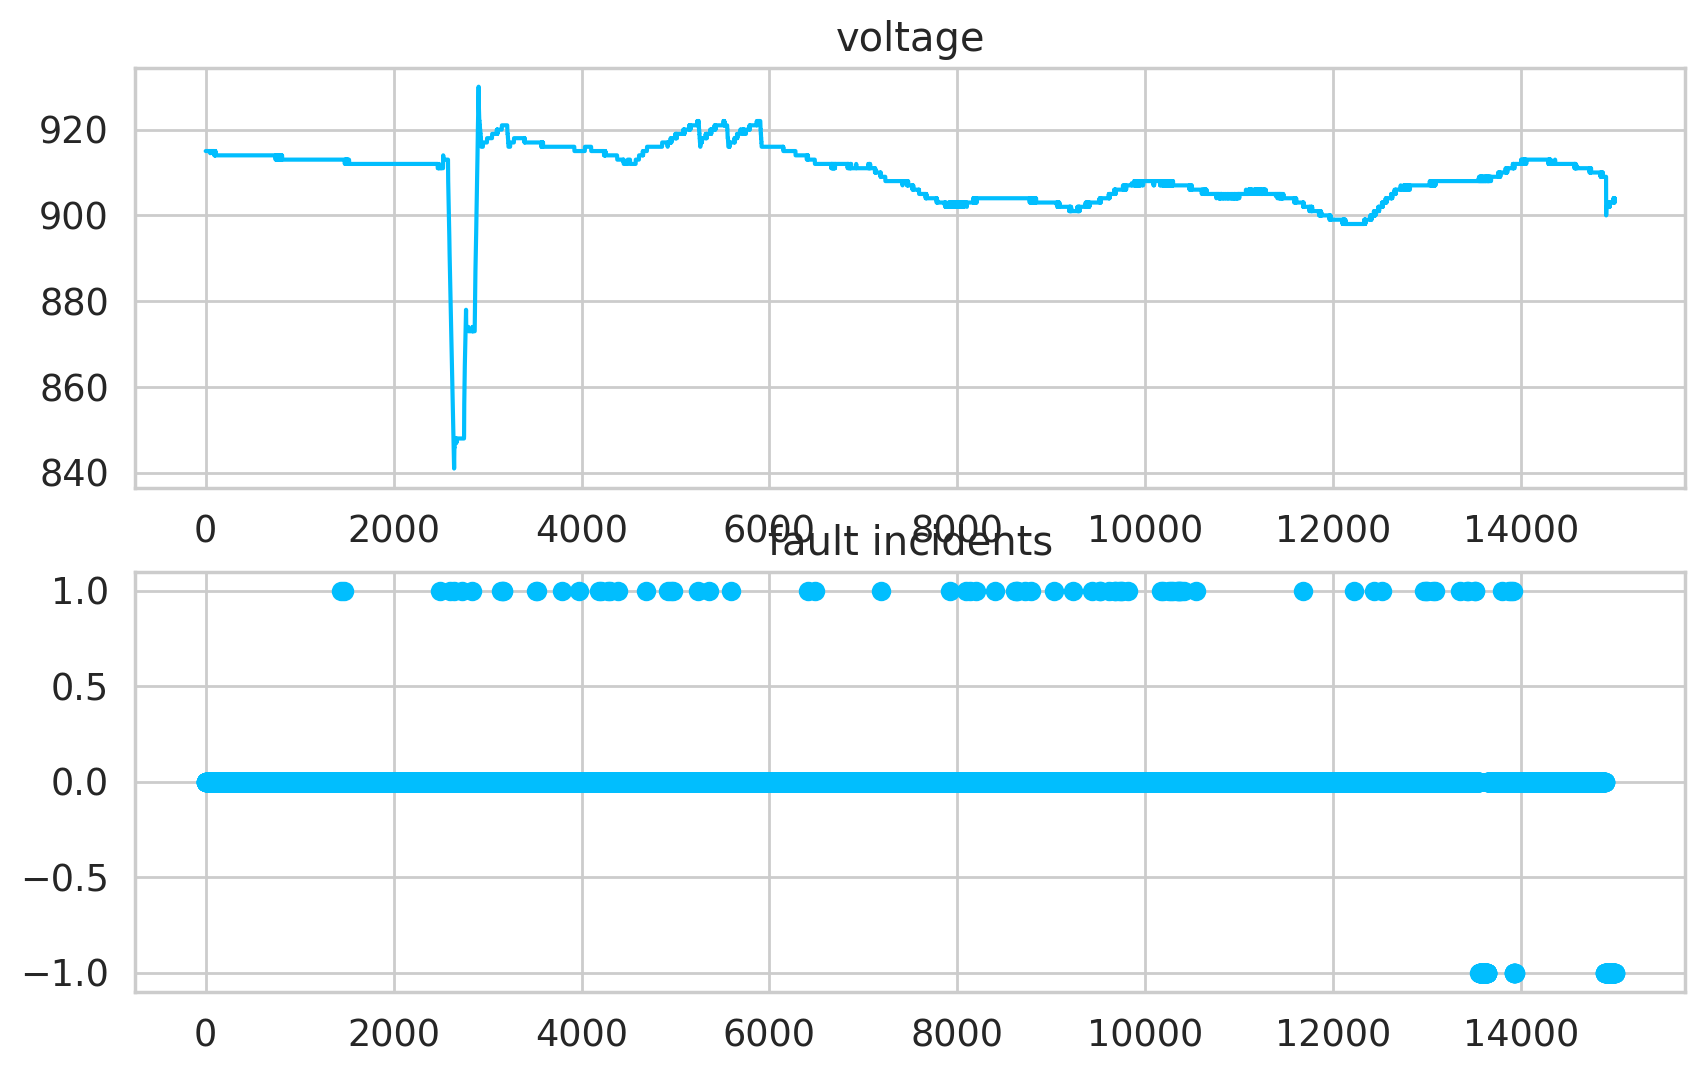

In [128]:
# fault region
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,3 * 2))

axs[0].plot(fault_voltage_data)
axs[0].set_title("voltage")
fault_incidents = fault_data[45000:60000]
axs[1].scatter(range(len(fault_incidents)), fault_incidents)
axs[1].set_title("fault incidents")

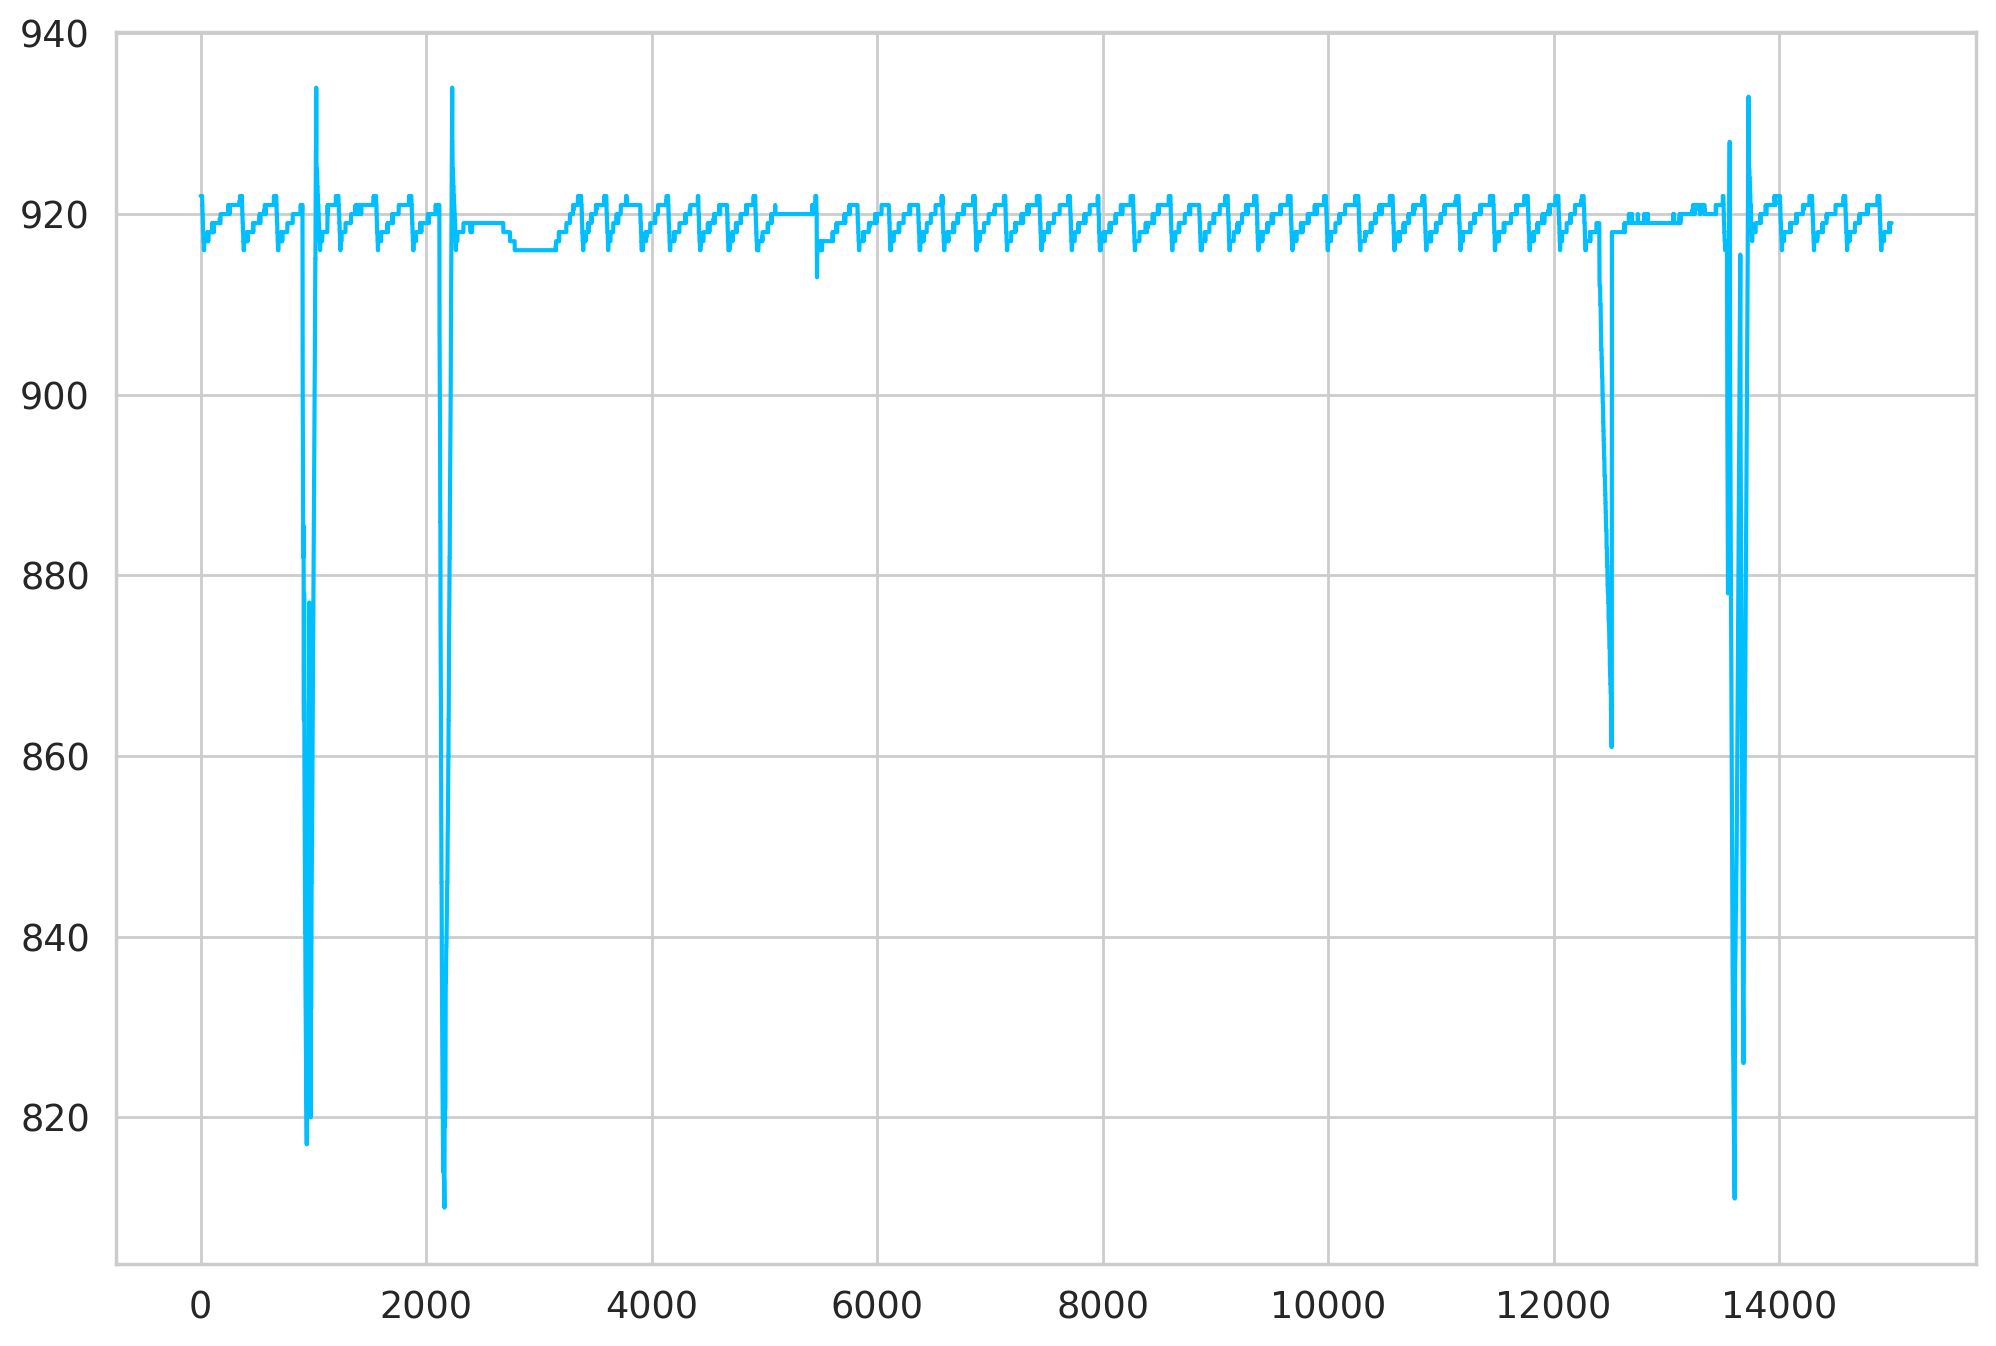

In [47]:
# test region
plt.plot(test_voltage_data)

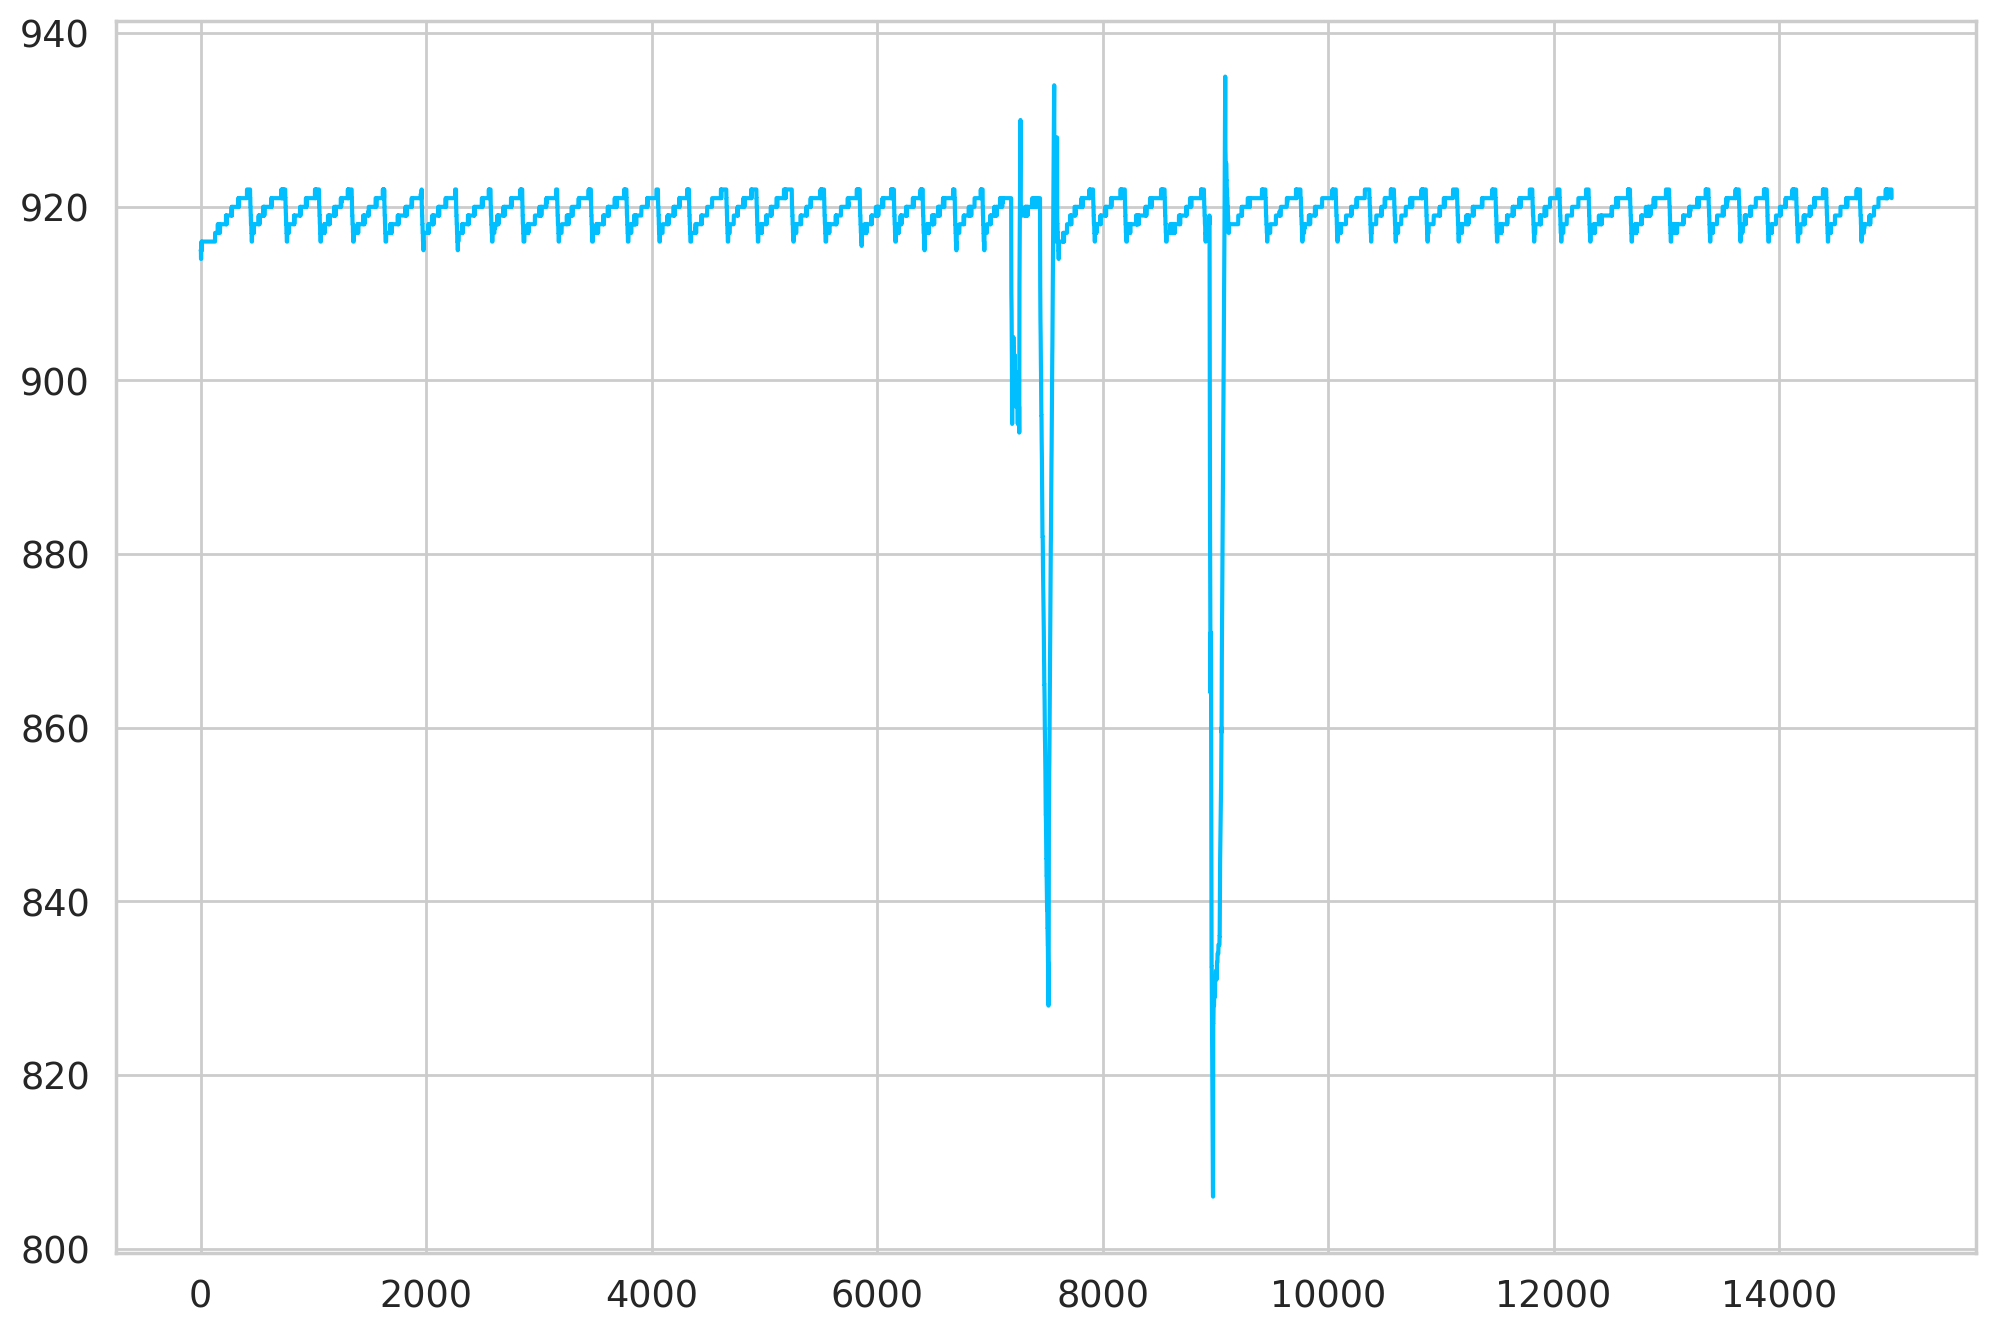

In [48]:
# test region
plt.plot(val_voltage_data)

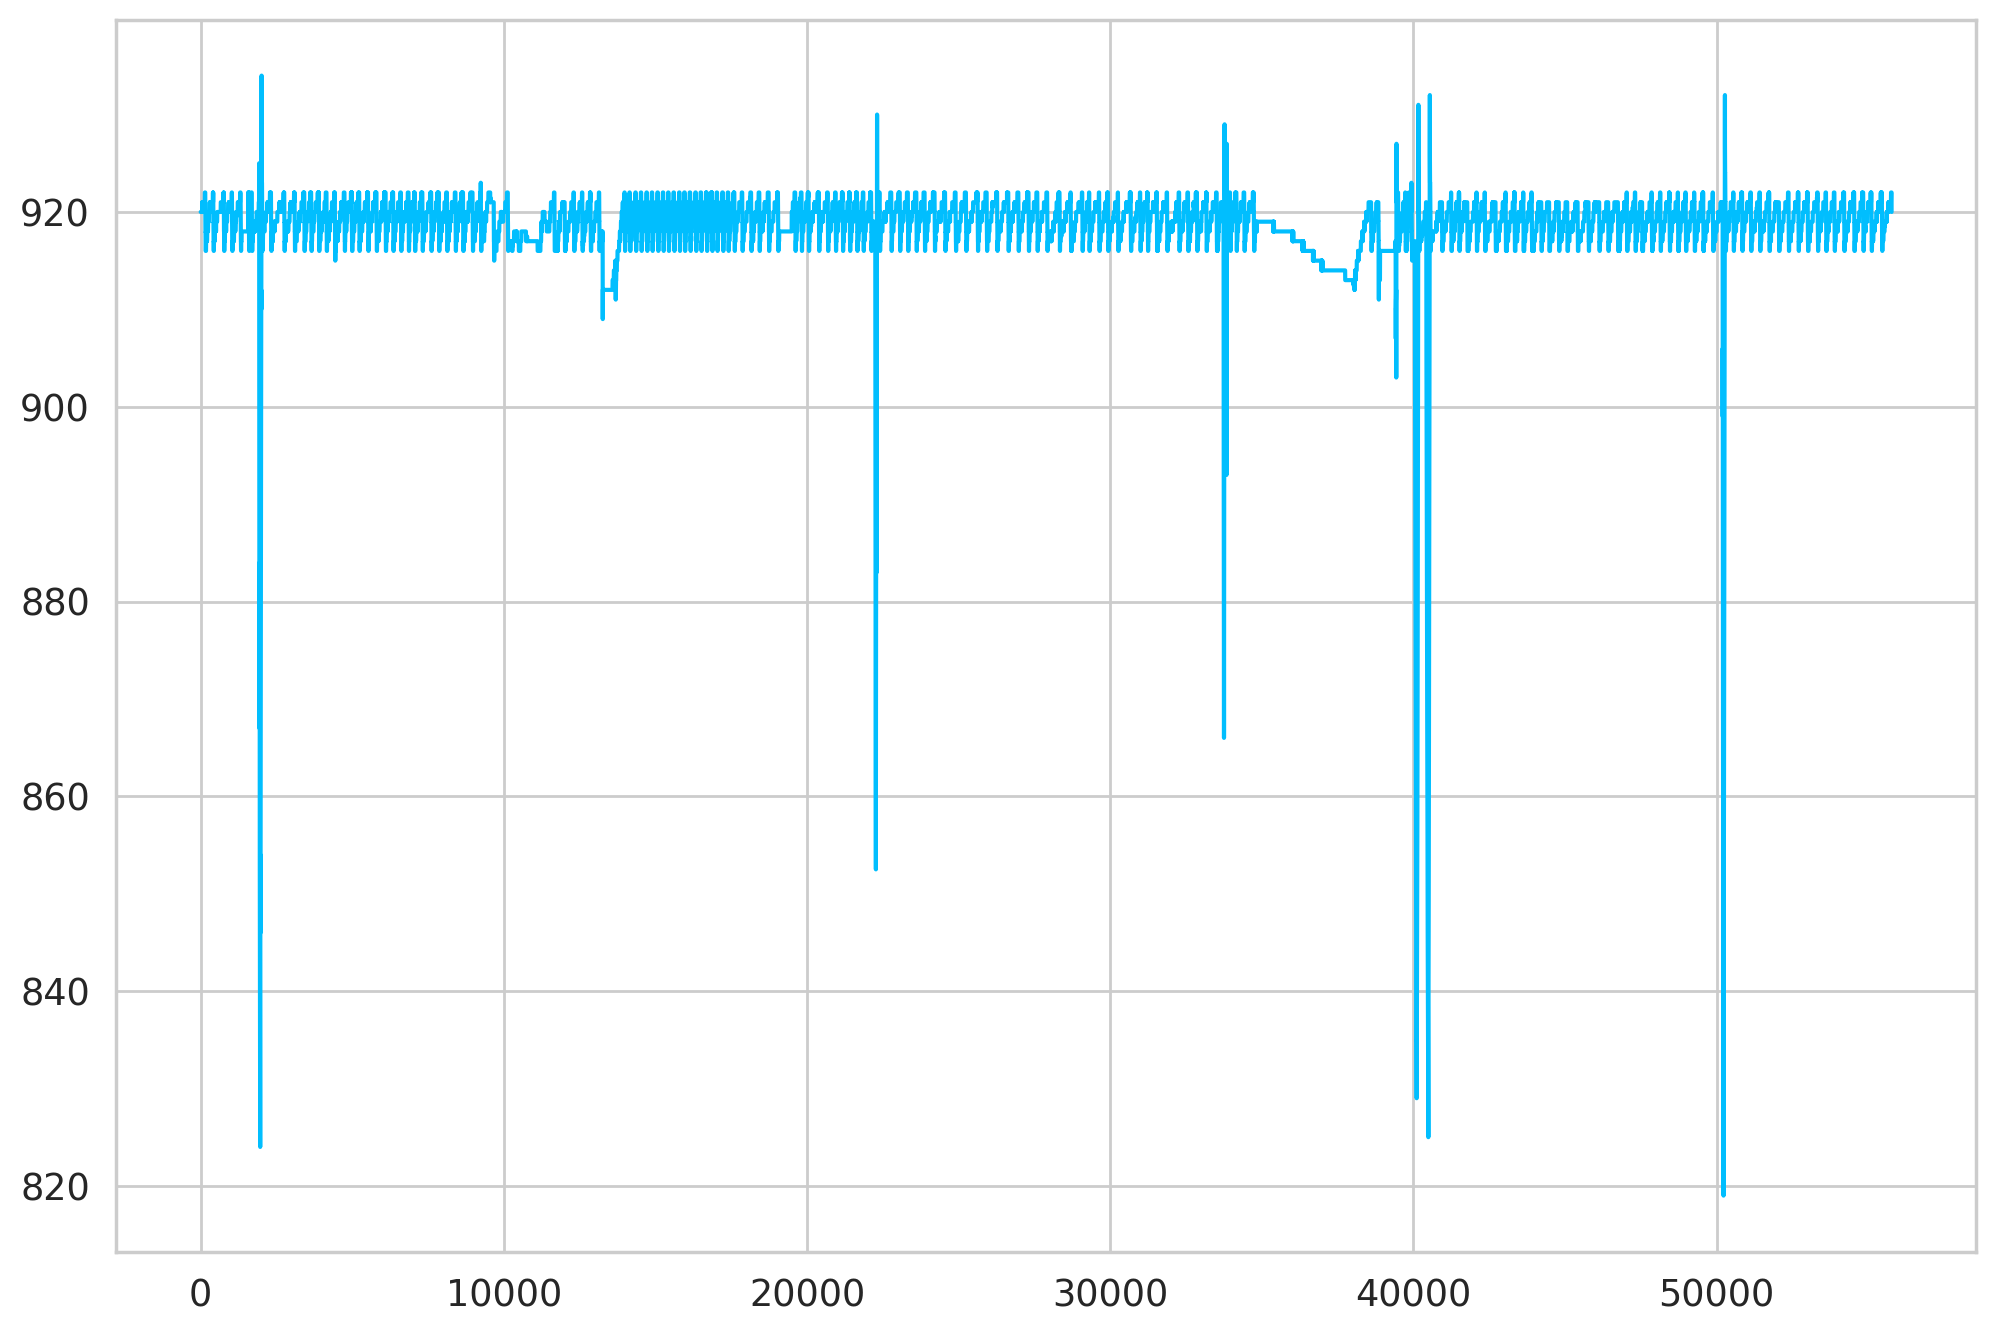

In [40]:

# train region
# plt.plot(voltage_data[145000:])
plt.plot(train_voltage_data)

## Data Processing

In [29]:
train_voltage_data.to_numpy().shape

(55774,)

In [30]:
55774 / 500

111.548

In [35]:
test_voltage_data.to_numpy().shape

(25000,)

In [36]:
25000 / 500

50.0

In [53]:
data = train_voltage_data.to_numpy()
segment_size = 100
segments = [ torch.tensor(data[i:i + segment_size]).unsqueeze(1).float() for i in range(0, len(data), segment_size) ]


In [56]:
if (segments[-1].shape[0] != segment_size):
    segments.pop()

In [57]:
torch.stack(segments).shape

torch.Size([557, 100, 1])

In [58]:
mean = np.mean(train_voltage_data)
stdev = np.std(train_voltage_data)

def create_dataset(series, segment_size, mean, stdev):
    # normalize the data
    data = (series.to_numpy() - mean)/stdev
    segments = [ torch.tensor(data[i:i + segment_size]).unsqueeze(1).float() for i in range(0, len(data), segment_size) ]
    # reject the last segment if it doesn't fit the shape
    if (segments[-1].shape[0] != segment_size):
        segments.pop()
    n_seq, seq_len, n_features = torch.stack(segments).shape

    return segments, seq_len, n_features


In [59]:
segment_size = 100
train_dataset, seq_len, n_features = create_dataset(train_voltage_data, segment_size, mean, stdev)
val_dataset, _, _ = create_dataset(val_voltage_data, segment_size, mean, stdev)
test_normal_dataset, _, _ = create_dataset(test_voltage_data, segment_size, mean, stdev)
test_anomaly_dataset, _, _ = create_dataset(fault_voltage_data, segment_size, mean, stdev)

## Encoder Decoder

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [61]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [62]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [63]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [64]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

## Training

In [65]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [66]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=10
)

Epoch 1: train loss 83876.04766045781 val loss 76590.19979166667
Epoch 2: train loss 69409.47180066202 val loss 62160.938072916666
Epoch 3: train loss 55019.510905240124 val loss 47822.004479166666
Epoch 4: train loss 40701.095496241025 val loss 33518.067044270836
Epoch 5: train loss 26405.11348462747 val loss 19228.23103515625
Epoch 6: train loss 12124.039359676559 val loss 5028.084357096354
Epoch 7: train loss 1190.5766426237096 val loss 489.6685514322917
Epoch 8: train loss 445.39513634180037 val loss 488.57960042317706
Epoch 9: train loss 445.98794736468386 val loss 489.6590458170573
Epoch 10: train loss 443.86239300767227 val loss 489.81301350911457


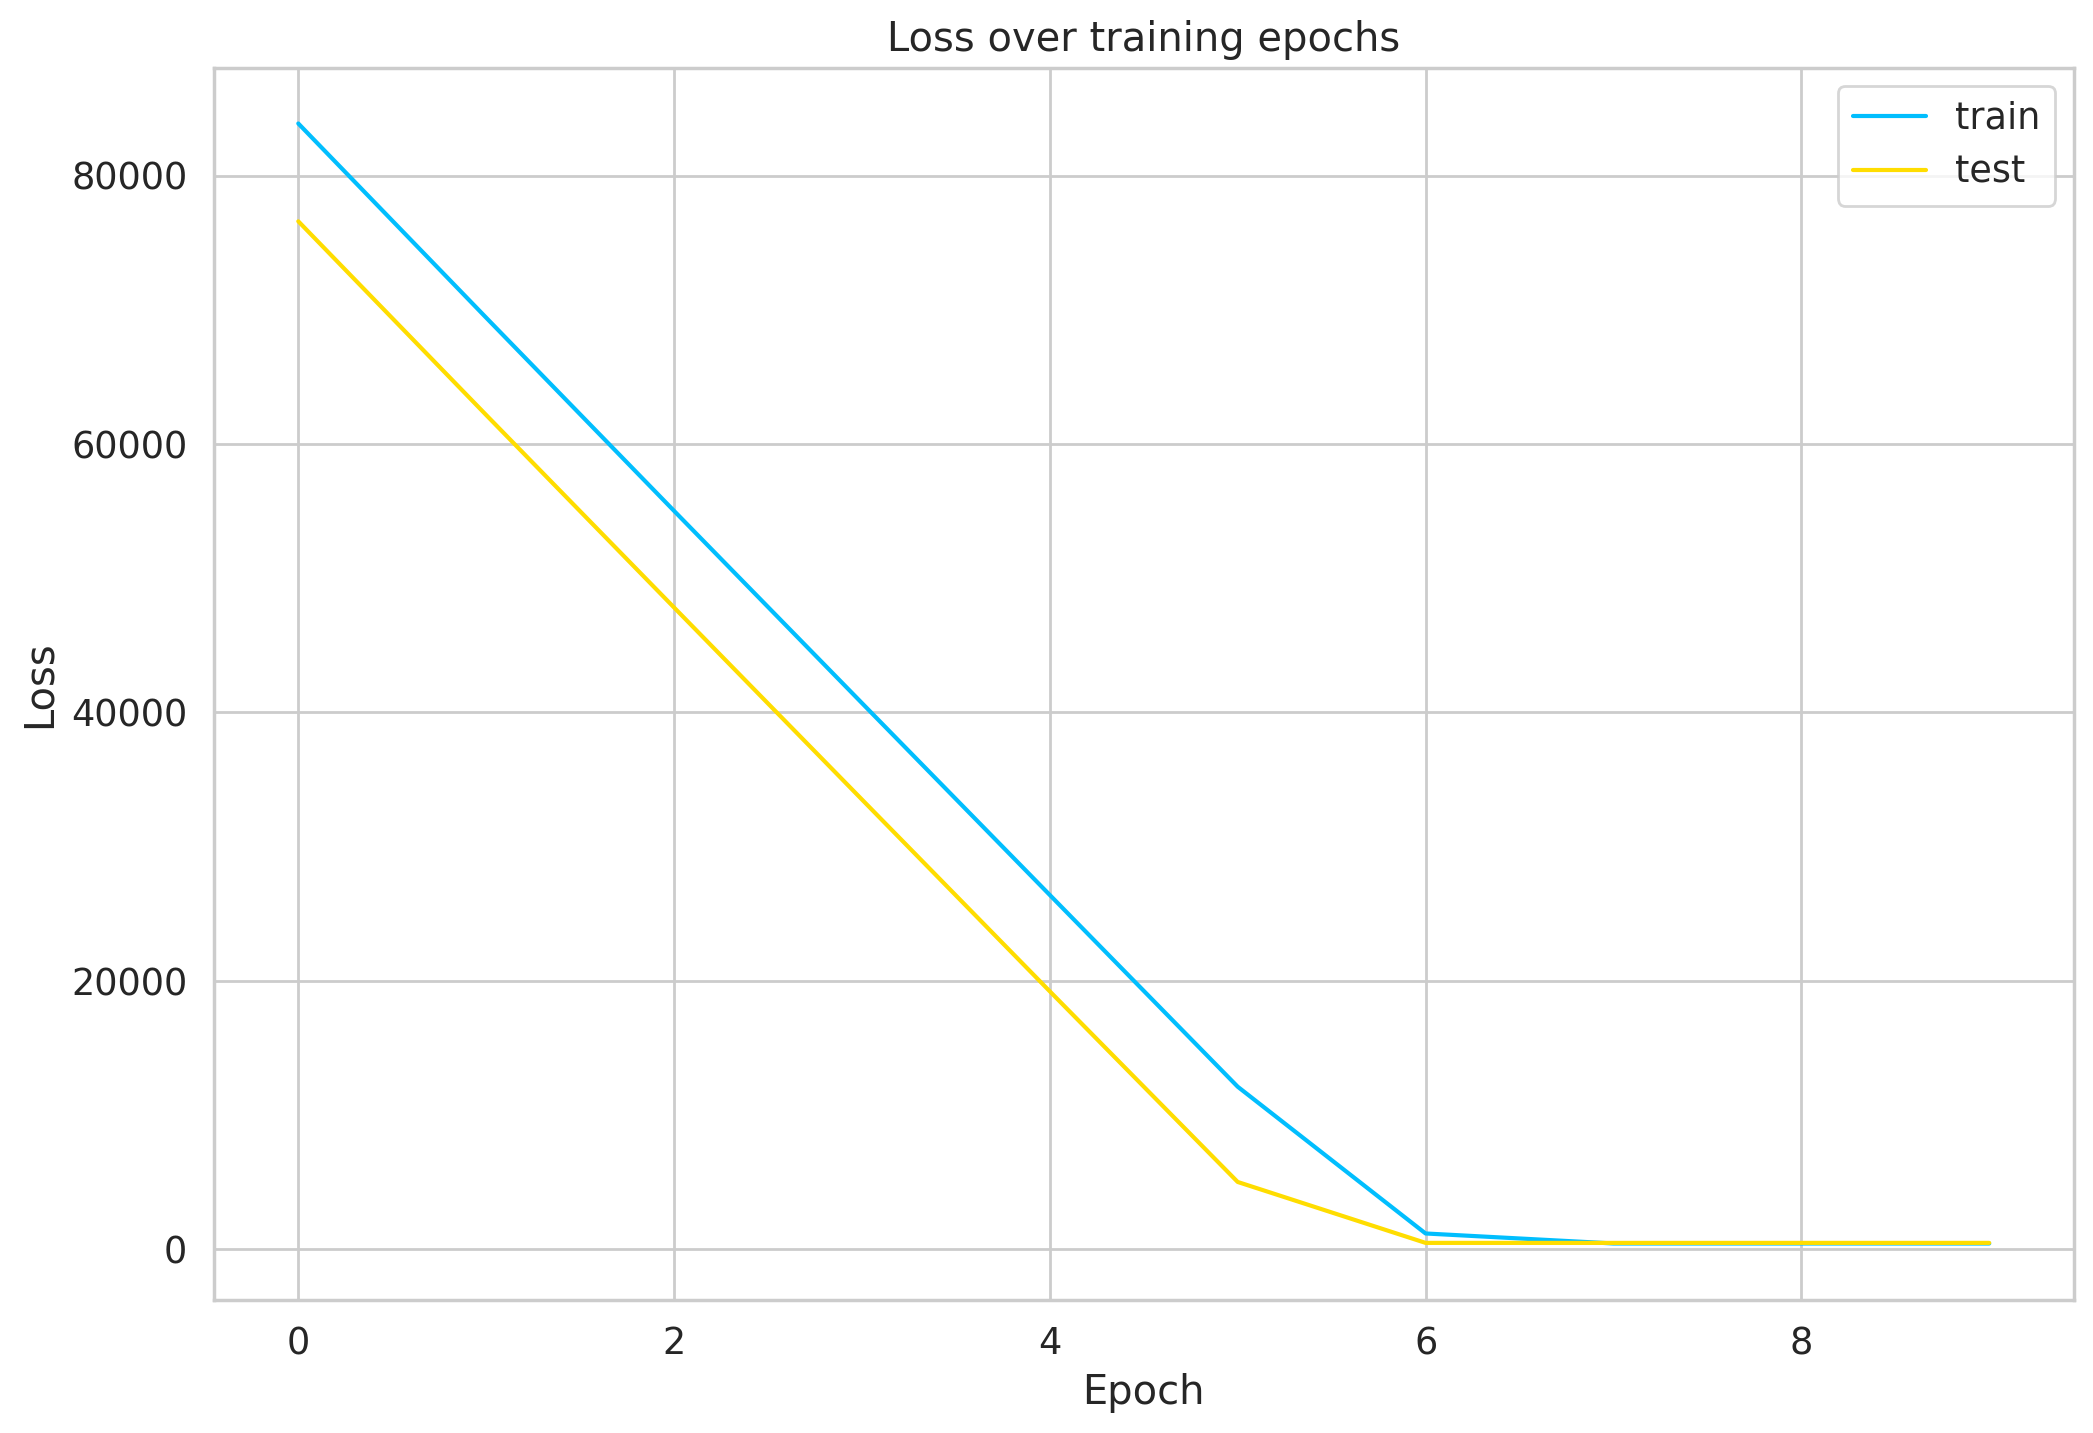

In [67]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

## Save the model


In [68]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

In [69]:
# reload the model
# model.torch.load('model.pth')
# model = model.to(device)

## Check reconstruction error

In [71]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

In [82]:
_, losses = predict(model, test_normal_dataset)
losses[:100]

[478.3055419921875,
 324.8333740234375,
 323.153564453125,
 426.354248046875,
 400.283935546875,
 310.18212890625,
 423.1041259765625,
 409.283935546875,
 288.3319091796875,
 6717.36279296875,
 769.3988037109375,
 375.0321044921875,
 436.6552734375,
 294.88232421875,
 364.153564453125,
 446.8544921875,
 384.1339111328125,
 318.0609130859375,
 423.754150390625,
 378.783935546875,
 289.281982421875,
 6582.95556640625,
 1024.248779296875,
 359.783935546875,
 336.283935546875,
 332.783935546875,
 347.783935546875,
 496.783935546875,
 614.783935546875,
 614.783935546875,
 614.783935546875,
 546.283935546875,
 355.183349609375,
 420.35400390625,
 350.0330810546875,
 383.153564453125,
 415.7130126953125,
 353.574462890625,
 374.153564453125,
 469.783935546875,
 330.7822265625,
 459.854736328125,
 371.48388671875,
 331.074462890625,
 466.655517578125,
 308.3328857421875,
 414.7042236328125,
 387.2337646484375,
 332.153564453125,
 489.4053955078125,
 336.7330322265625,
 274.153564453125,
 274.1

<Axes: ylabel='Density'>

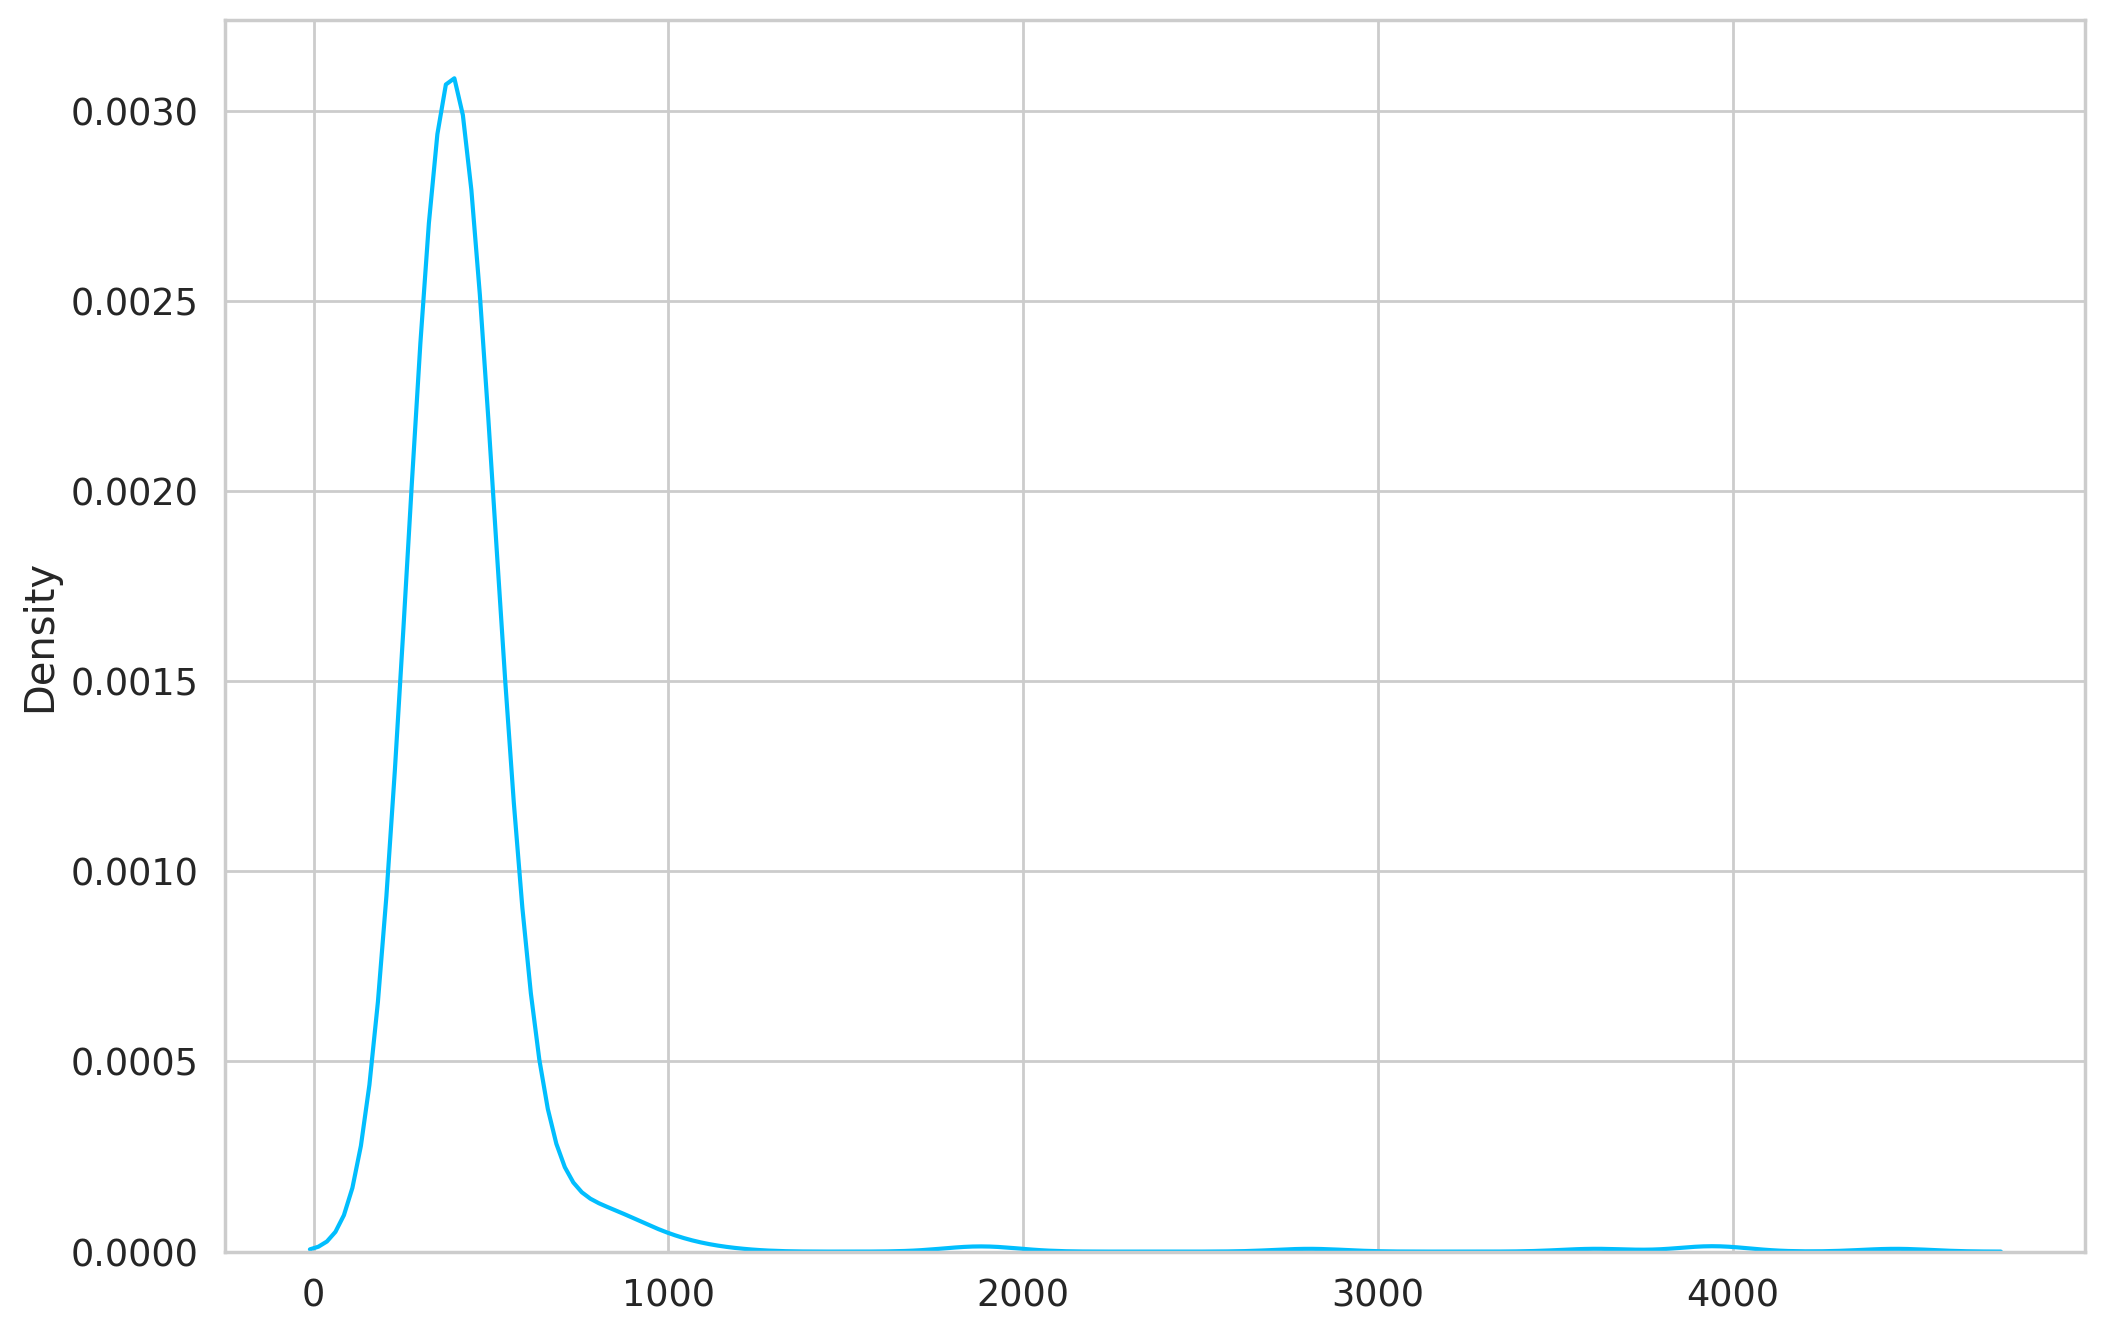

In [79]:
_, losses = predict(model, train_dataset)
sns.kdeplot(losses)

<Axes: ylabel='Density'>

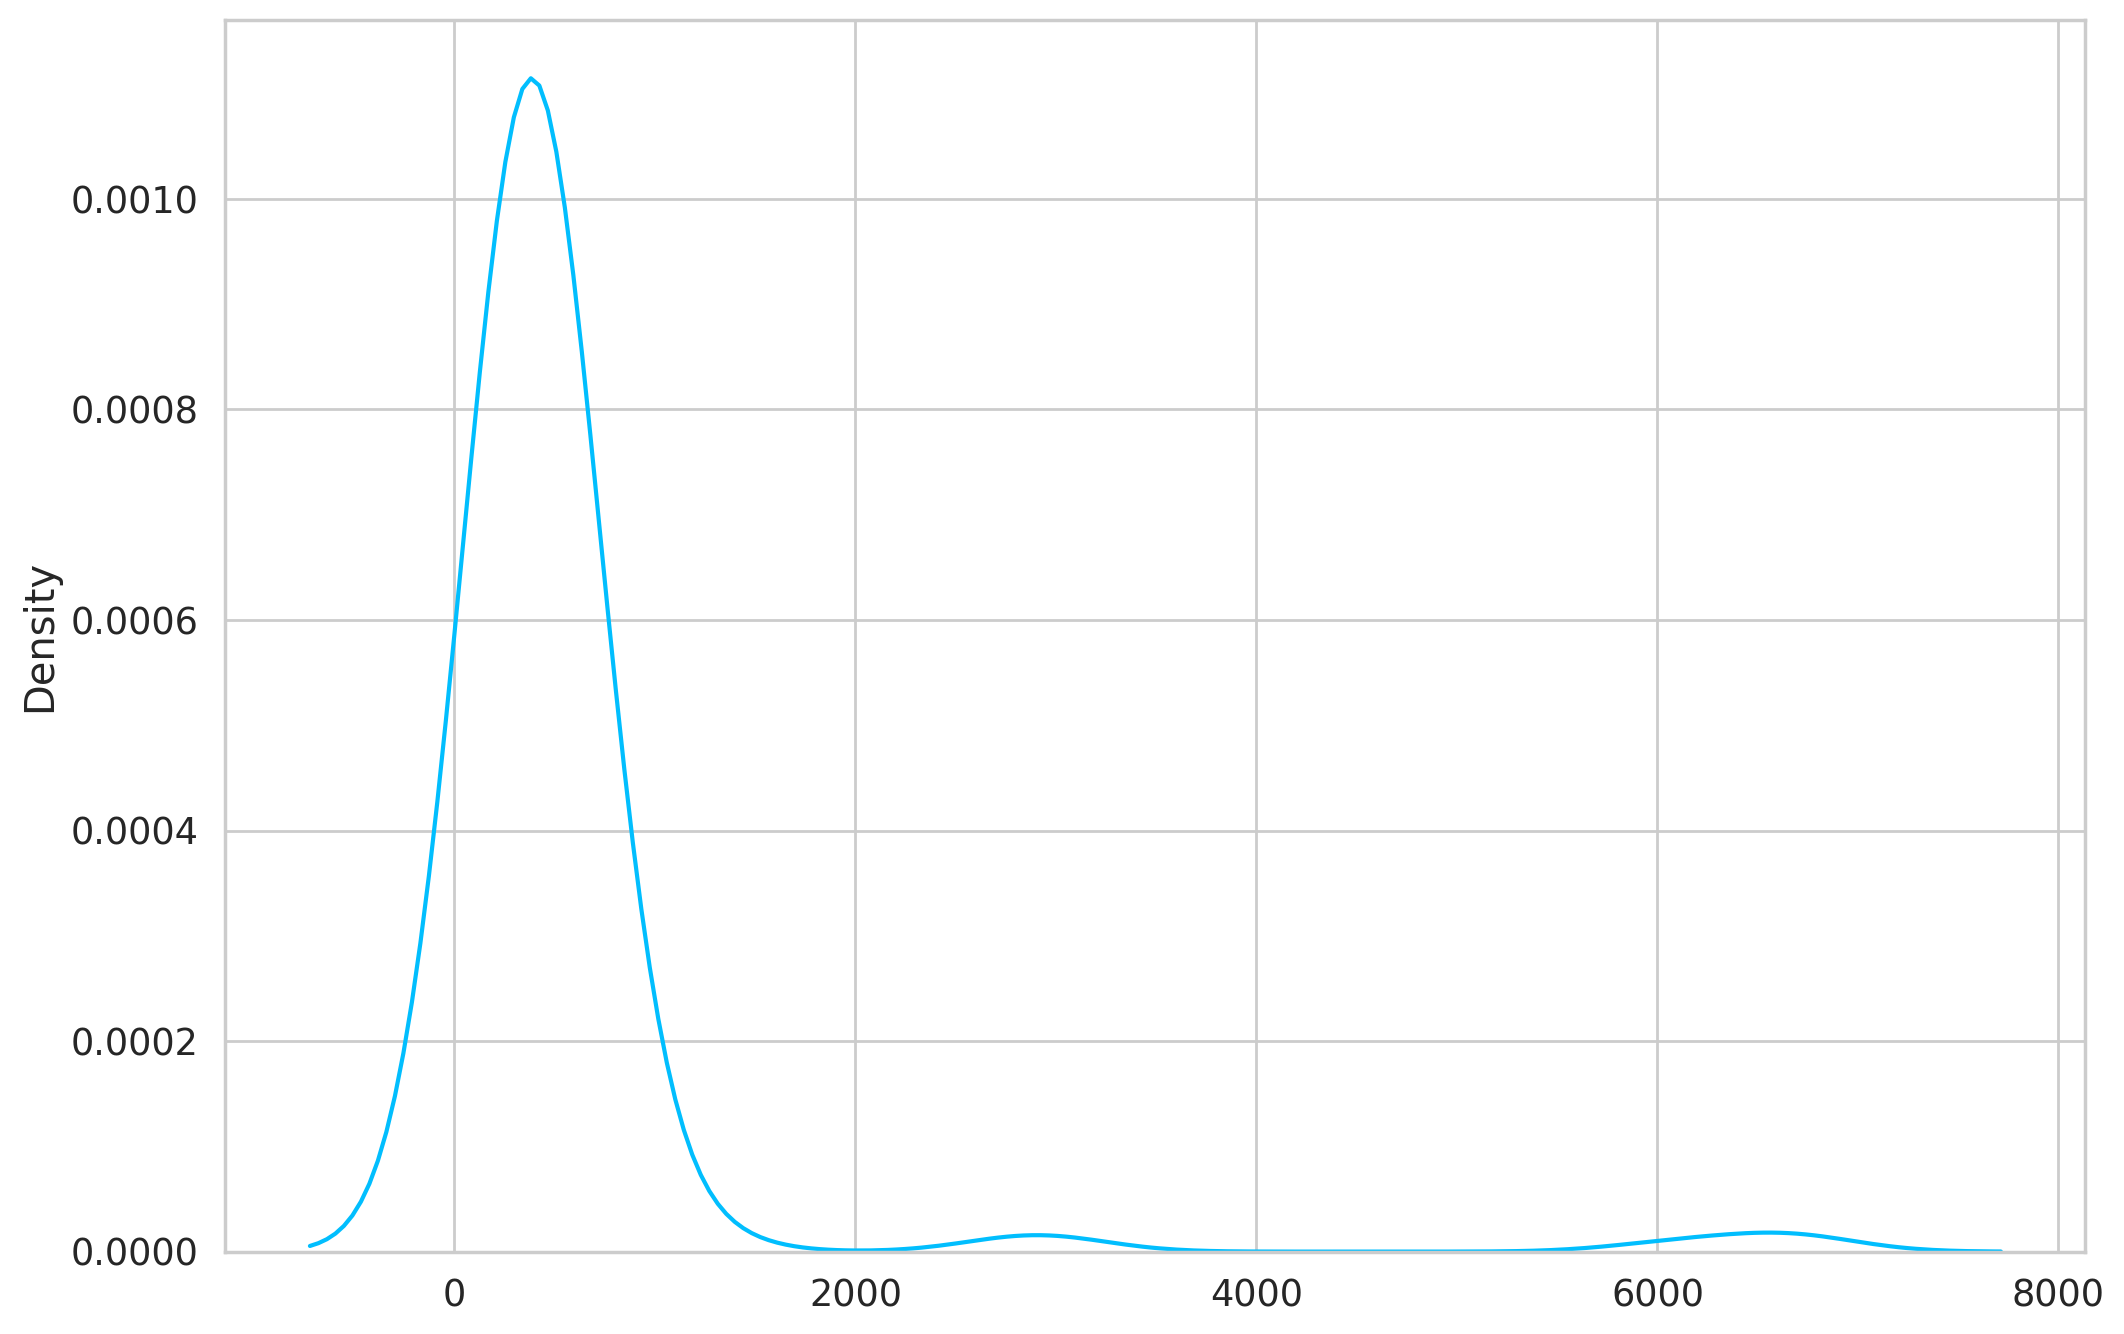

In [80]:
# _, losses = predict(model, train_dataset)
_, losses = predict(model, test_normal_dataset)
sns.kdeplot(losses)

<Axes: ylabel='Density'>

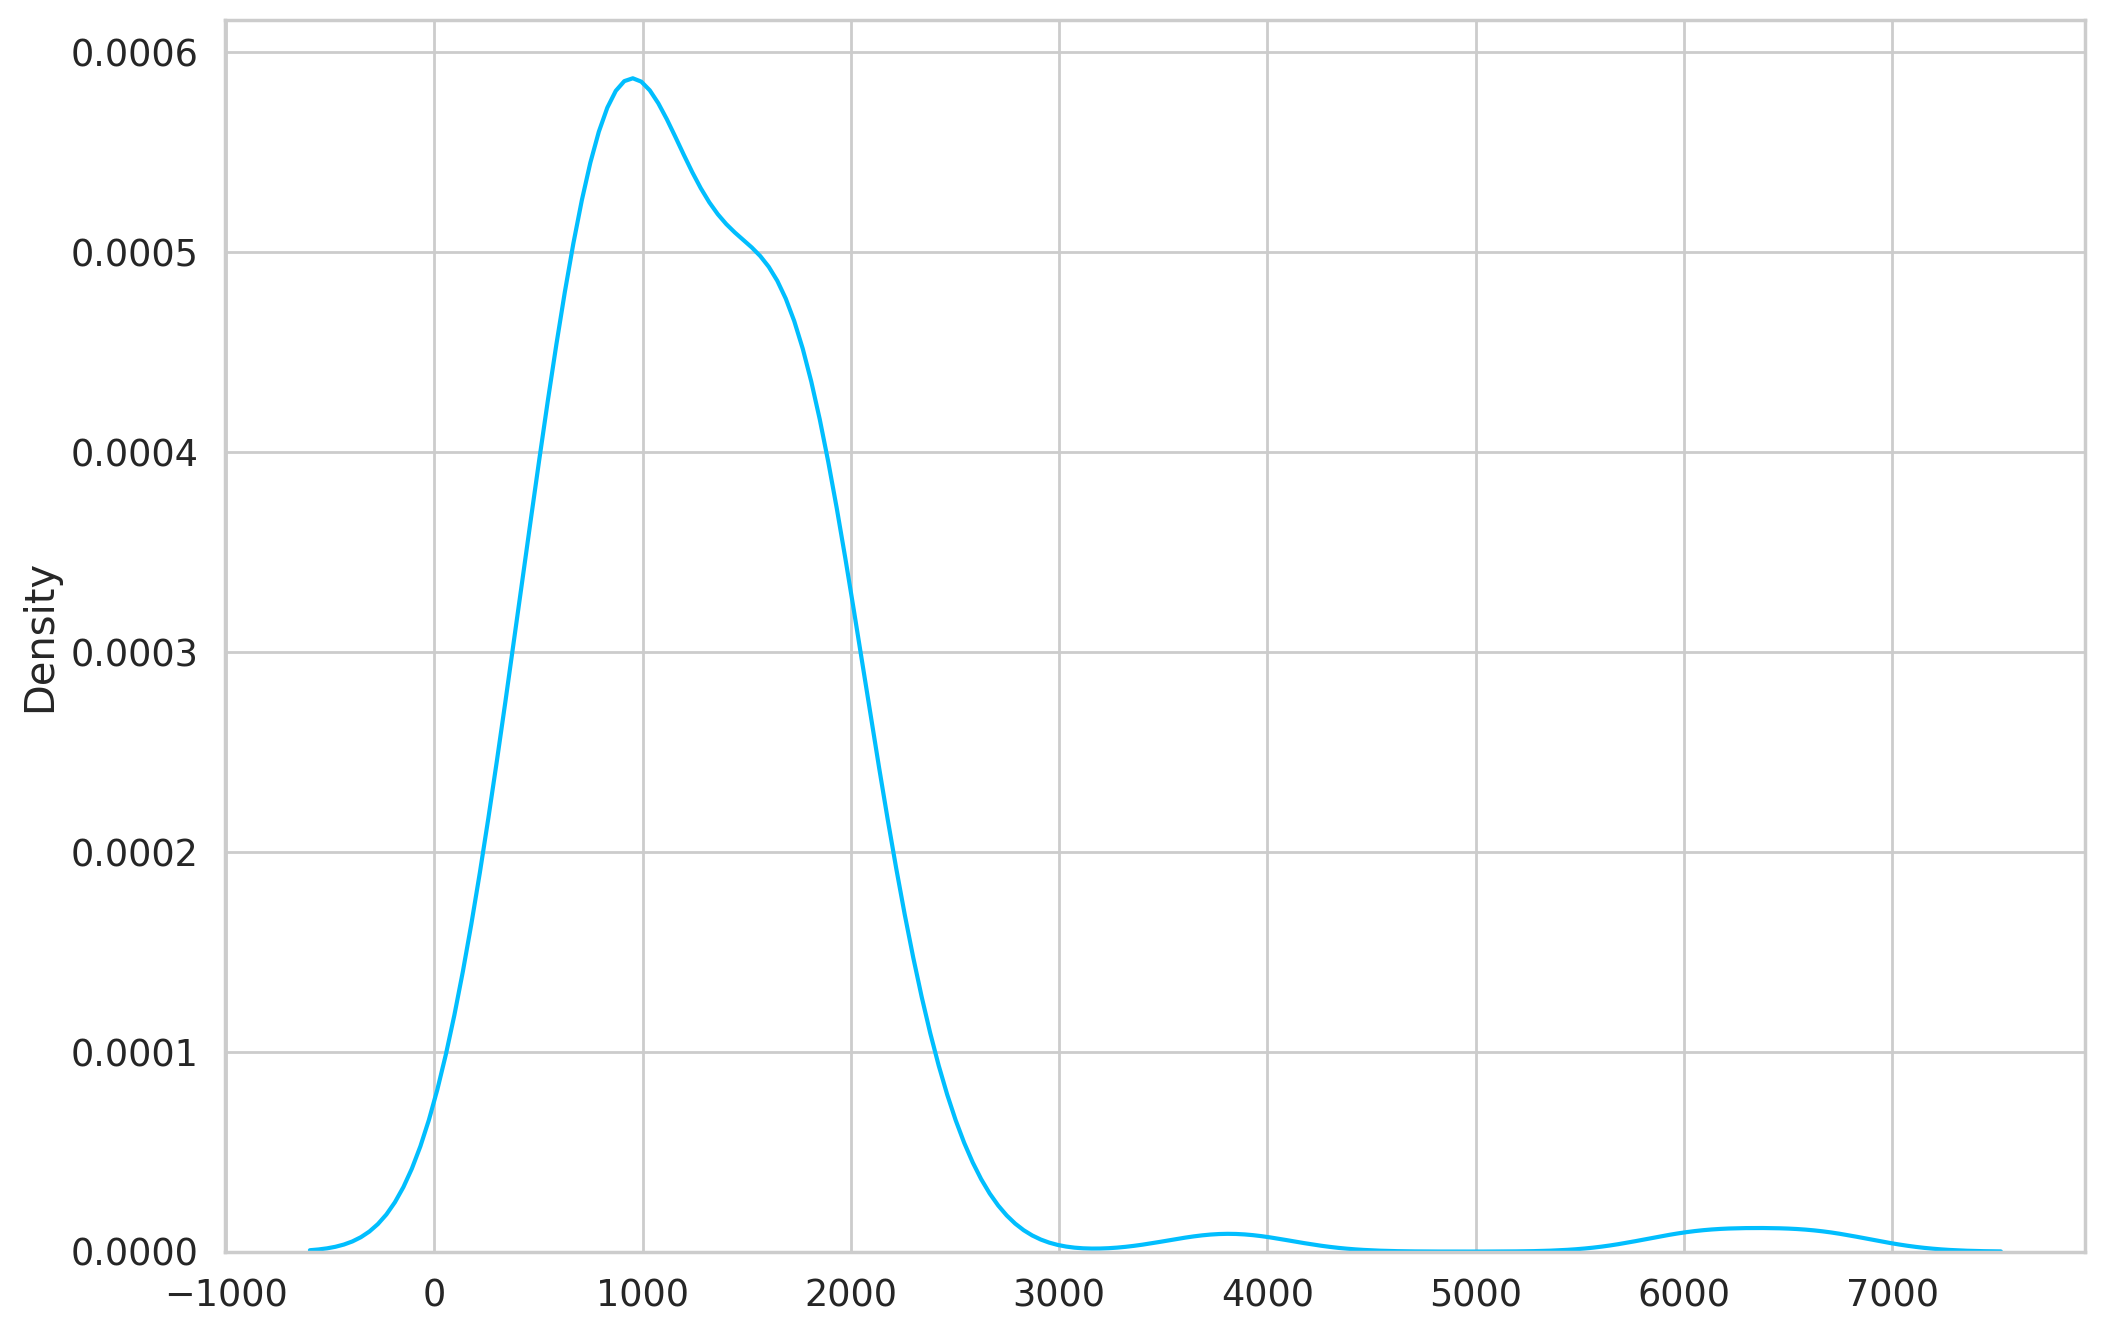

In [81]:
# _, losses = predict(model, train_dataset)
_, losses = predict(model, test_anomaly_dataset)
sns.kdeplot(losses)

## Predictions

Compute THRESHOLD with training set data

In [105]:
predictions, losses = predict(model, train_dataset)

In [106]:
loss_array = np.array(losses)

In [107]:
stdev = np.std(loss_array)
mean = np.mean(loss_array)
THRESHOLD = mean + stdev 

Check on test_normal_dataset

In [111]:
_, losses = predict(model, test_normal_dataset)
exceed_count = sum(l > THRESHOLD for l in losses)
print(f'number of intervals exceeding 1 std dev loss: {exceed_count}/{len(test_normal_dataset)}')

number of intervals exceeding 1 std dev loss: 8/150


Check on test_anomaly_dataset

In [112]:
_, losses = predict(model, test_anomaly_dataset)
exceed_count = sum(l > THRESHOLD for l in losses)
print(f'number of intervals exceeding 1 std dev loss: {exceed_count}/{len(test_normal_dataset)}')

number of intervals exceeding 1 std dev loss: 118/150


## plot construction error vs original

In [113]:
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])

    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()

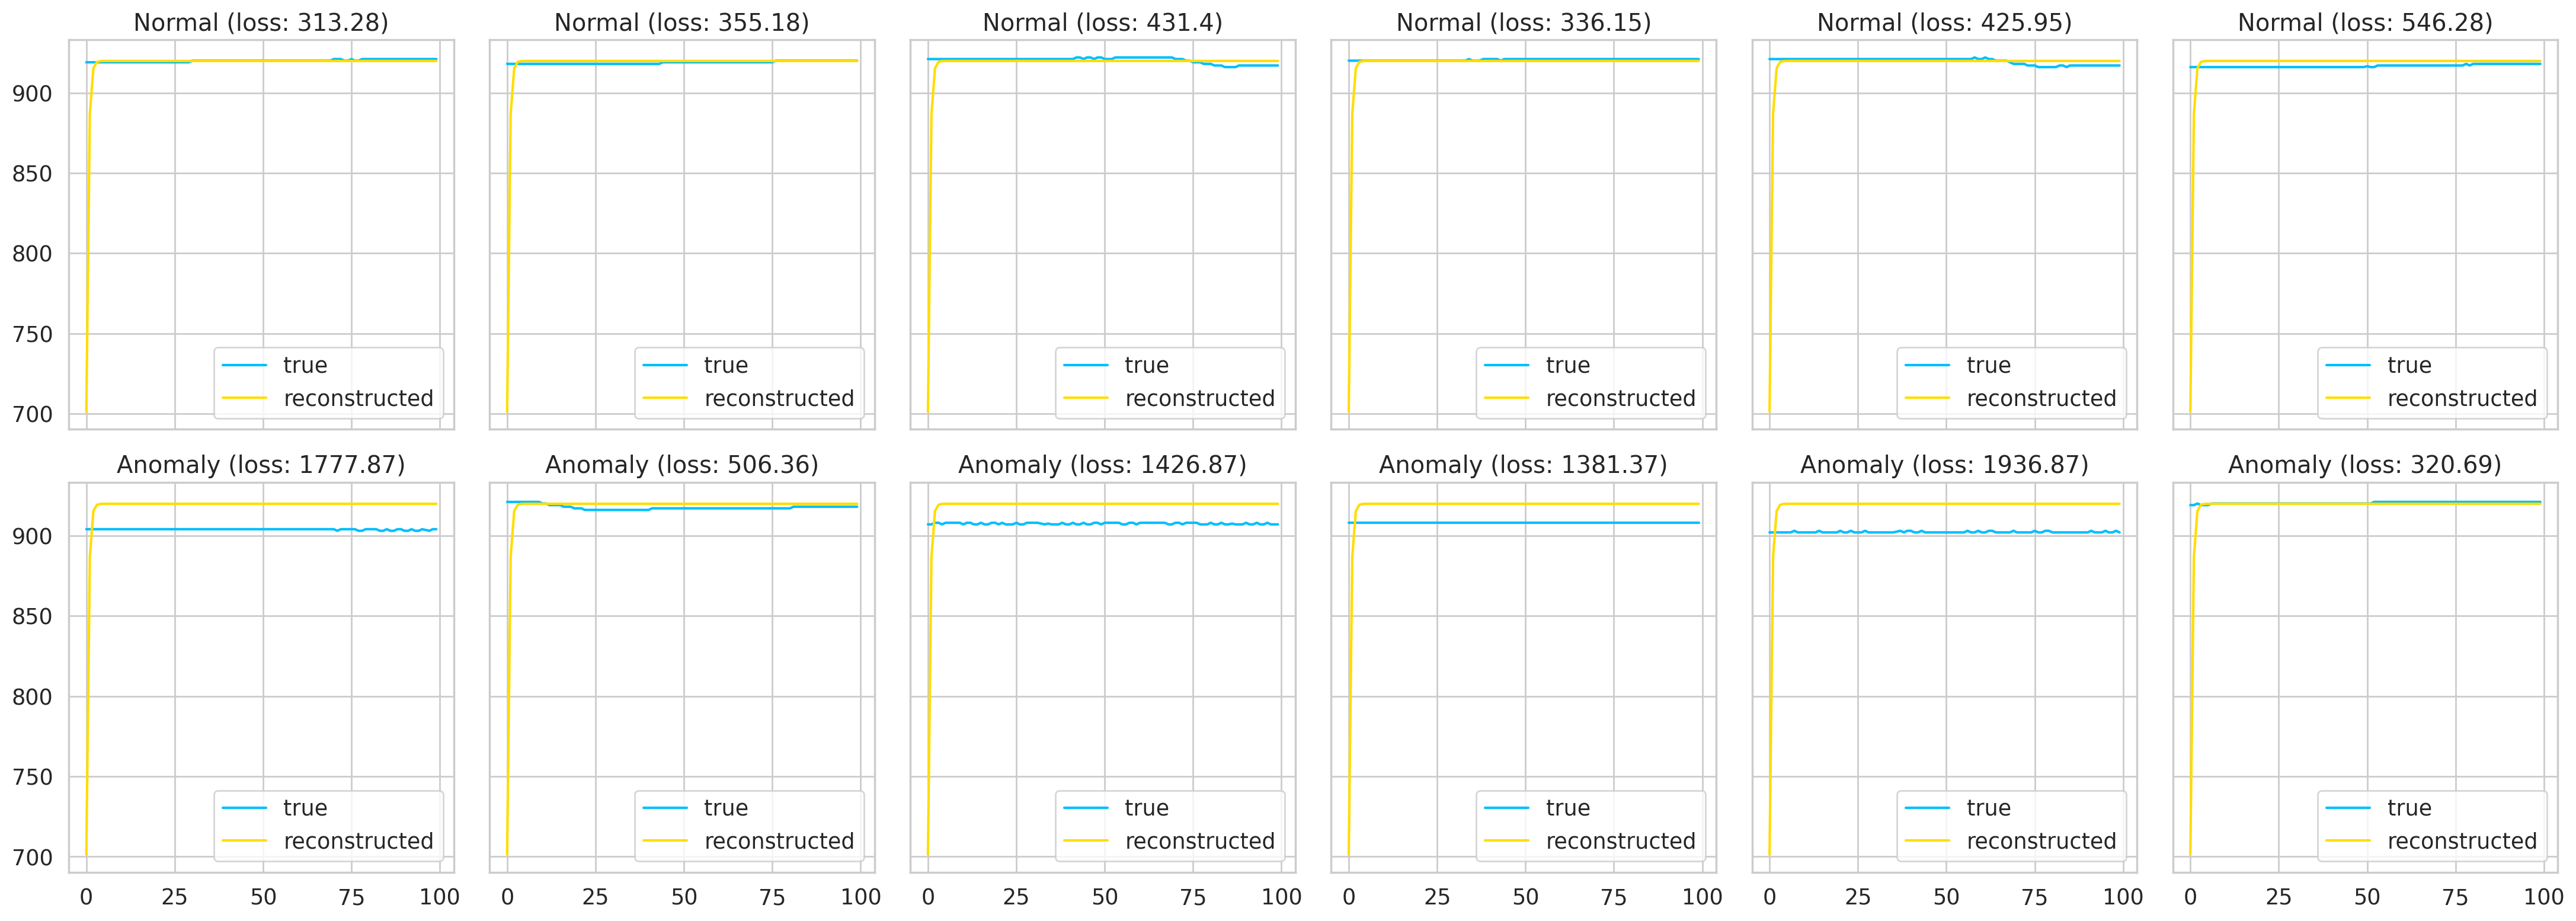

In [123]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=6,
    sharey=True,
    sharex=True,
    figsize=(22, 8)
)

sample_size = 6
sample_indices = random.sample(range(0,len(test_normal_dataset)), sample_size)

sampled_test_normal_dataset = [test_normal_dataset[i] for i in sample_indices]
sampled_test_anomaly_dataset = [test_anomaly_dataset[i] for i in sample_indices]

for i, data in enumerate(sampled_test_normal_dataset):
    plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(sampled_test_anomaly_dataset):
    plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();